In [ ]:
import numpy as np
from scipy.io import wavfile
import librosa
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import warnings
import os
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D,Conv2D,MaxPooling2D,LeakyReLU
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from matplotlib import pyplot as plt
import random
import pathlib
from tensorflow.keras.layers.experimental import preprocessing
from IPython import display
from tensorflow.keras.models import Sequential
import tensorflow as tf
from keras.layers.normalization import BatchNormalization
# from sklearn.preprocessing import StandardScaler
import sklearn


In [ ]:
np.set_printoptions(threshold=np.inf)

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

train_audio_path = '/content/drive/MyDrive/Voices-wav'
labels = os.listdir(train_audio_path)
labels.remove('.ipynb_checkpoints')
print(labels)

no_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
print(no_of_recordings)

['auto', 'dasti', 'garm', 'roshan', 'sard', 'tarik']
[244, 244, 253, 255, 254, 247]


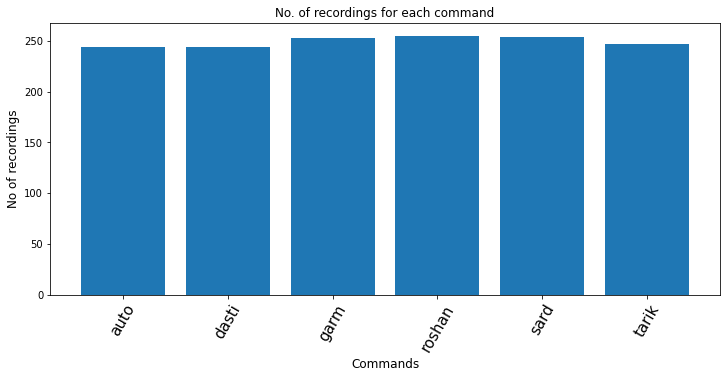

In [ ]:
# draw number of audio files for each label
plt.figure(figsize=(12, 5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

(array([ 46., 181., 307., 250., 358., 255.,  61.,  33.,   5.,   1.]),
 array([0.57349206, 0.94414286, 1.31479365, 1.68544444, 2.05609524,
        2.42674603, 2.79739683, 3.16804762, 3.53869841, 3.90934921,
        4.28      ]),
 <a list of 10 Patch objects>)

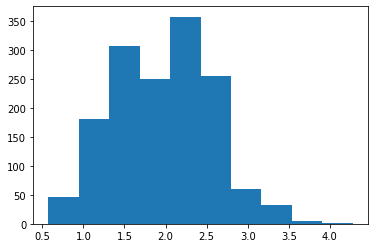

In [ ]:
# plotting duration of audio files
duration_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples) / sample_rate))
plt.hist(np.array(duration_of_recordings))

In [ ]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr=16000)
        samples = librosa.resample(samples, sample_rate, 10000)

        # feature extraction using MFCC
        # samples = librosa.feature.mfcc(samples, sr=10000, n_mfcc=13)

        # normalization
        # scaler = sklearn.preprocessing.StandardScaler()
        # samples = scaler.fit_transform(samples)
        samples = librosa.util.fix_length(samples, 10000, axis=-1)

        if len(samples) == 10000:
            all_wave.append(samples)
            all_label.append(label)

auto
dasti
garm
roshan
sard
tarik


In [ ]:
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)
y = np_utils.to_categorical(y, num_classes=len(labels))
all_wave = np.array(all_wave).reshape(-1, 10000, 1)

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave), np.array(y), stratify=y, test_size=0.2,
                                            random_state=777, shuffle=True)

In [ ]:
K.clear_session()

inputs = Input(shape=(10000, 1))

# First Conv1D layer
conv = Conv1D(32, 7, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

# Second Conv1D layer
conv = Conv1D(32, 13, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

# Third Conv1D layer
conv = Conv1D(64, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

# Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

# Flatten layer
conv = Flatten()(conv)

# Dense Layer 1
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.2)(conv)

# Dense Layer 2
conv = Dense(32, activation='relu')(conv)
conv = Dropout(0.2)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 9994, 32)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3331, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3331, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3319, 32)          13344     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1106, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1106, 32)          0     

Epoch 1/10
48/48 [==============================] - 26s 527ms/step - loss: 1.7937 - accuracy: 0.1609 - val_loss: 1.7876 - val_accuracy: 0.2300
Epoch 2/10
48/48 [==============================] - 25s 525ms/step - loss: 1.7799 - accuracy: 0.2160 - val_loss: 1.7894 - val_accuracy: 0.1900
Epoch 3/10
48/48 [==============================] - 25s 524ms/step - loss: 1.7793 - accuracy: 0.1813 - val_loss: 1.7659 - val_accuracy: 0.2467
Epoch 4/10
48/48 [==============================] - 25s 531ms/step - loss: 1.7342 - accuracy: 0.2536 - val_loss: 1.6990 - val_accuracy: 0.2800
Epoch 5/10
48/48 [==============================] - 25s 529ms/step - loss: 1.6784 - accuracy: 0.2844 - val_loss: 1.6229 - val_accuracy: 0.3667
Epoch 6/10
48/48 [==============================] - 25s 527ms/step - loss: 1.5841 - accuracy: 0.3171 - val_loss: 1.6025 - val_accuracy: 0.3667
Epoch 7/10
48/48 [==============================] - 25s 527ms/step - loss: 1.5237 - accuracy: 0.3689 - val_loss: 1.5024 - val_accuracy: 0.3967

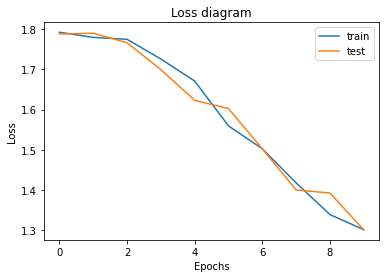

In [ ]:
# choosing loss function and optimization algorithm
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# if 1==1 :
if os.path.exists('classification_model2.h5'):
    model = load_model('classification_model2.h5')
else:
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.00001)
    mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit(x_tr, y_tr, epochs=10, callbacks=[es, mc], batch_size=25, validation_data=(x_val, y_val))
    model.save('classification_model2.h5')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss diagram')
    plt.show()

In [ ]:
def predict(audio):
    prob = model.predict(audio.reshape(1, 10000, 1))
    ind = np.argmax(prob[0])
    return classes[ind]

In [ ]:
# test model on 10 random samples
for i in range(10):
    index = random.randint(0, len(x_val) - 1)
    samples = x_val[index].ravel()
    ipd.Audio(samples, rate=8000)
    print("Audio:", classes[np.argmax(y_val[index])], " | Text:", predict(samples))

Audio: sard  | Text: dasti
Audio: auto  | Text: dasti
Audio: auto  | Text: auto
Audio: tarik  | Text: sard
Audio: garm  | Text: dasti
Audio: roshan  | Text: roshan
Audio: garm  | Text: auto
Audio: sard  | Text: sard
Audio: tarik  | Text: sard
Audio: sard  | Text: sard
